# fNP intro & purpose

This noteboook is to test the fNP module in `modules/fNP.py`.

# imports

In [1]:
# Import required libraries
import sys
import os
import torch
import matplotlib.pyplot as plt

# Auto discover map/ path - robust method
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
print(f"Current directory: {current_dir}")

# Look for map directory in current directory and parent directories
map_path = None
search_dir = current_dir

# Search up the directory tree for map folder
for _ in range(5):  # Limit search to 5 levels up
    potential_map = os.path.join(search_dir, 'map')
    if os.path.isdir(potential_map) and os.path.isdir(os.path.join(potential_map, 'modules')):
        map_path = potential_map
        break
    search_dir = os.path.dirname(search_dir)

if map_path:
    print(f"Found map directory at: {map_path}")
    if map_path not in sys.path:
        sys.path.insert(0, map_path)
    # Also add the parent directory to path for relative imports
    parent_dir = os.path.dirname(map_path)
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
else:
    print("Warning: Could not find map directory with modules folder")
    # Fallback to original method
    sys.path.insert(0, "map")

print(f"Python path includes: {[p for p in sys.path[:3]]}")

# Import custom modules
import modules.utilities as utl
import modules.fnp as fNP

Current directory: /Users/cbissolotti/anl/projects/tmd/map/tests
Found map directory at: /Users/cbissolotti/anl/projects/tmd/map
Python path includes: ['/Users/cbissolotti/anl/projects/tmd', '/Users/cbissolotti/anl/projects/tmd/map', '/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python313.zip']


# fNP setup

## Load config file

In [2]:
# Load the configuration from a YAML file
# Since we're running from tests/, we need to go up one level to access inputs/
config_file_path = '../inputs/fNPconfig.yaml'
config = utl.load_yaml_file(config_file_path)
print("Configuration loaded successfully!")
print(f"Config keys: {list(config.keys())}")

Configuration loaded successfully!
Config keys: ['hadron', 'zeta', 'evolution', 'pdfs', 'ffs']


## instantiate the model & define (x, b)

In [4]:
# Instantiate the model.
# The object model_fNP itself is not just a dictionary; 
# it is an nn.Module that contains an nn.ModuleDict as one of its attributes.
model_fNP = fNP.fNPManager(config)

[fNPManager] Initializing PDF and FF fNP modules
[fNPManager] Setting up shared evolution: g2=0.1284, trainable=True
[fNPManager] Initialized 8 PDF flavor modules
[fNPManager] Initialized 8 FF flavor modules
✅ fNP manager initialization completed



In [5]:
# Define example inputs.
x = torch.tensor(0.3)
b = torch.tensor(1.0)

# Explicit vector inputs.
xv = torch.tensor([0.0001, 0.002, 0.03, 0.1, 0.3])
bv = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# To evaluate fNP on all combinations of values in two vectors 
# (for example, x values along one axis and b values along the other), 
# you’ll need to prepare your inputs accordingly, then create a mesh grid
x_values = torch.logspace(-5  , 0, steps=10)   # e.g., shape (10,)
b_values = torch.linspace(1e-5, 10, steps=10)  # e.g., shape (10,)

# Create a meshgrid of x and b values. X and B will each have shape (10, 10)
X, B = torch.meshgrid(x_values, b_values, indexing = 'ij')

# fNP functional forms in latex

$$
f(x,b) = N_{Pevol} \cdot \frac{
            g_1 \, \exp\left(-g_1\left(\frac{b}{2}\right)^2\right)
          + \lambda^2 \, g_{1B}^2 \left(1 - g_{1B}\left(\frac{b}{2}\right)^2\right)
            \exp\left(-g_{1B}\left(\frac{b}{2}\right)^2\right)
          + g_{1C} \, \lambda_2^2 \, \exp\left(-g_{1C}\left(\frac{b}{2}\right)^2\right)
        }{
            g_1 + \lambda^2 \, g_{1B}^2 + g_{1C} \, \lambda_2^2
        }
        \\
        \text{where } 
        \\
        g_1 = N_1 \left(\frac{x}{x_{\text{hat}}}\right)^{\sigma_1}
            \left(\frac{1-x}{1-x_{\text{hat}}}\right)^{\alpha_1^2},\\[1mm]
        \\    
        g_{1B} = N_{1B} \left(\frac{x}{x_{\text{hat}}}\right)^{\sigma_2}
            \left(\frac{1-x}{1-x_{\text{hat}}}\right)^{\alpha_2^2},\\[1mm]
        \\    
        g_{1C} = N_{1C} \left(\frac{x}{x_{\text{hat}}}\right)^{\sigma_3}
            \left(\frac{1-x}{1-x_{\text{hat}}}\right)^{\alpha_3^2},\quad
        \\    
        x_{\text{hat}} = 0.1.
$$

In [6]:
# Create base TMD PDF instance using default MAP22 parameters
default_params = fNP.MAP22_DEFAULT_PDF_PARAMS['init_params']
default_mask = fNP.MAP22_DEFAULT_PDF_PARAMS['free_mask']

fNP_base = fNP.TMDPDFBase(n_flavors=1, init_params=default_params, free_mask=default_mask)
print("Base fNP TMD PDF created successfully!")
print(f"Number of parameters: {len(default_params)}")

if hasattr(fNP_base, 'show_latex_formula'):
    fNP_base.show_latex_formula
else:
    print("LaTeX formula display not available")

############################################################################################################
# other two equivalent ways to show the latex formula (if IPython is available)
############################################################################################################
# from IPython.display import Latex
# 
# if hasattr(fNP_base, 'latex_formula'):
#     Latex(fNP_base.latex_formula)
#     utl.show_latex_formula(fNP_base.latex_formula) if hasattr(utl, 'show_latex_formula') else None

Base fNP TMD PDF created successfully!
Number of parameters: 11


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
# Create a TMD PDF for u-quark flavor using default parameters
fNP_u = fNP.TMDPDFBase(n_flavors=1, 
                       init_params=fNP.MAP22_DEFAULT_PDF_PARAMS['init_params'], 
                       free_mask=fNP.MAP22_DEFAULT_PDF_PARAMS['free_mask'])
print("fNP for u-quark flavor created successfully!")
if hasattr(fNP_u, 'show_latex_formula'):
    fNP_u.show_latex_formula
else:
    print("LaTeX formula display not available")

fNP for u-quark flavor created successfully!


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
# Create a TMD PDF for d-quark flavor using default parameters  
fNP_d = fNP.TMDPDFBase(n_flavors=1, 
                       init_params=fNP.MAP22_DEFAULT_PDF_PARAMS['init_params'], 
                       free_mask=fNP.MAP22_DEFAULT_PDF_PARAMS['free_mask'])
print("fNP for d-quark flavor created successfully!")
if hasattr(fNP_d, 'show_latex_formula'):
    fNP_d.show_latex_formula
else:
    print("LaTeX formula display not available")

fNP for d-quark flavor created successfully!


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Checks & tests

## fNP point by point $(x, b)$

Results for all PDF flavors:
u: 0.9906814098358154
ubar: 0.9844084978103638
d: 0.9896194934844971
dbar: 0.9844084978103638
s: 0.9877688884735107
sbar: 0.9898249506950378
c: 0.9922710657119751
cbar: 0.9922710657119751


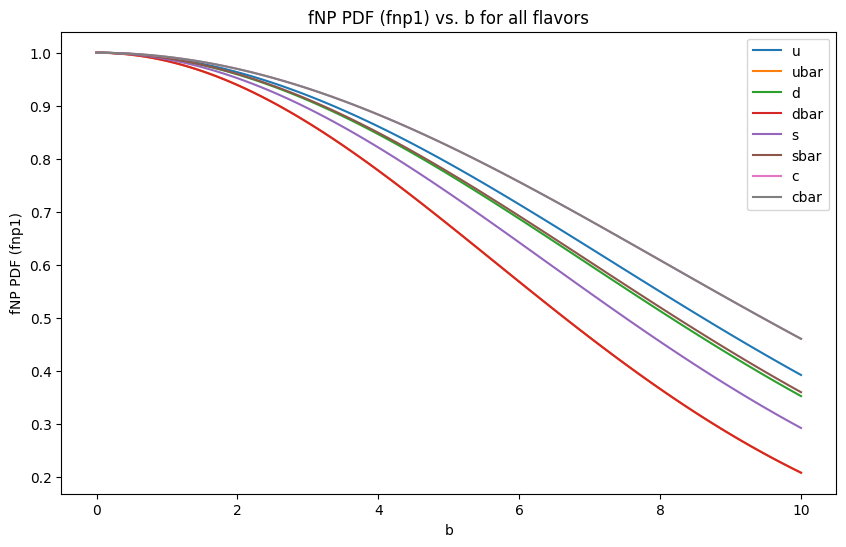

In [9]:
# Check
# Evaluate the PDF model for all flavors (u, ubar, d, dbar, c, cbar, s, sbar).
results = model_fNP.forward_pdf(x, b)
print("Results for all PDF flavors:")
for flavor, val in results.items():
    print(f"{flavor}: {val.item()}")

# Call the plotting function.
utl.plot_fNP(model_fNP, x)

## fNP elementwise for x and b vectors
If x and b are both 1D tensors of the same shape (say, shape (N,)), then the result will also have shape (N,)

In [10]:
# For a given flavor, the forward_pdf method will be applied elementwise.
results = model_fNP.forward_pdf(xv, bv)  # xv and bv have both shape (5,)

# 'results' is a dictionary mapping flavor keys to output tensors of shape (5,)
for flavor, output in results.items():
    print(f"Flavor: {flavor}, Output shape: {output.shape}")
    
# To see the output tensor for the "d" flavor, do:
print("Result tensor for flavor 'd':")
print(results['d'])     

Flavor: u, Output shape: torch.Size([5])
Flavor: ubar, Output shape: torch.Size([5])
Flavor: d, Output shape: torch.Size([5])
Flavor: dbar, Output shape: torch.Size([5])
Flavor: s, Output shape: torch.Size([5])
Flavor: sbar, Output shape: torch.Size([5])
Flavor: c, Output shape: torch.Size([5])
Flavor: cbar, Output shape: torch.Size([5])
Result tensor for flavor 'd':
tensor([0.9530, 0.7333, 0.4199, 0.3581, 0.7704], grad_fn=<MulBackward0>)


## fNP on a grid of x and b values

For a grid evaluation (Cartesian product): Use torch.meshgrid to generate 2D tensors for x and b. The output will then be a 2D tensor (with the shape of the grid).

In [11]:
# To evaluate fNP on all combinations of values in two vectors 
# (for example, x values along one axis and b values along the other), 
# you'll need to prepare your inputs accordingly, then create a mesh grid.
x_values = torch.logspace(-5, 0, steps=10)   # e.g., shape (10,)
b_values = torch.linspace(1e-5, 10, steps=10)  # e.g., shape (10,)

# Check elements in the meshgrid
print("x_values:")
print(x_values)
print("b_values:")
print(b_values)

# Create a meshgrid of x and b values. X and B will each have shape (10, 10)
X, B = torch.meshgrid(x_values, b_values, indexing = 'ij')

# For a given flavor, the forward_pdf method will be applied on the mesh.
results = model_fNP.forward_pdf(X, B)  # X and B have shape (10,10)

# 'results' is a dictionary mapping flavor keys to output tensors of shape (10,10)
# for flavor, output in results.items():
#     print(f"Flavor: {flavor}, Output shape: {output.shape}")
    
# To see the output tensor for the "d" flavor, do:
print("Result tensor for flavor 'd':")
print(results['d'])    

# Access individual elements of the output tensor for the "d" flavor.
print("Output tensor for flavor 'd' at (x=0.1, b=2.0):")
print(results['d'][3, 1])
print(results['d'][3, 1].item())

x_values:
tensor([1.0000e-05, 3.5938e-05, 1.2915e-04, 4.6416e-04, 1.6681e-03, 5.9948e-03,
        2.1544e-02, 7.7426e-02, 2.7826e-01, 1.0000e+00])
b_values:
tensor([1.0000e-05, 1.1111e+00, 2.2222e+00, 3.3333e+00, 4.4445e+00, 5.5556e+00,
        6.6667e+00, 7.7778e+00, 8.8889e+00, 1.0000e+01])
Result tensor for flavor 'd':
tensor([[1.0000e+00, 9.5988e-01, 8.4894e-01, 6.9178e-01, 5.1938e-01, 3.5928e-01,
         2.2898e-01, 1.3445e-01, 7.2732e-02, 3.6247e-02],
        [1.0000e+00, 9.5086e-01, 8.1746e-01, 6.3540e-01, 4.4652e-01, 2.8369e-01,
         1.6294e-01, 8.4600e-02, 3.9705e-02, 1.6844e-02],
        [1.0000e+00, 9.3987e-01, 7.8030e-01, 5.7223e-01, 3.7066e-01, 2.1205e-01,
         1.0713e-01, 4.7794e-02, 1.8824e-02, 6.5447e-03],
        [1.0000e+00, 9.2659e-01, 7.3712e-01, 5.0341e-01, 2.9512e-01, 1.4849e-01,
         6.4105e-02, 2.3740e-02, 7.5389e-03, 2.0519e-03],
        [1.0000e+00, 9.1104e-01, 6.8886e-01, 4.3223e-01, 2.2500e-01, 9.7133e-02,
         3.4758e-02, 1.0302e-02, 2.5269

# update parameters - simulation of after minimization

=== Current Parameter Summary ===

fNP MANAGER PARAMETER SUMMARY (PDFs + FFs)
Total parameters: 161
Truly trainable parameters: 70
PyTorch trainable parameters: 161
Fixed parameters: 91

Shared Evolution Parameter:
  g2: 1 total (1 trainable, 0 fixed)

TMD PDF Parameters:
  u: 11 total (11 trainable, 0 fixed)
      mask: [T, T, T, T, T, T, T, T, T, T, T]
  ubar: 11 total (3 trainable, 8 fixed)
      mask: [T, T, F, T, F, F, F, F, F, F, F]
  d: 11 total (11 trainable, 0 fixed)
      mask: [T, T, T, T, T, T, T, T, T, T, T]
  dbar: 11 total (3 trainable, 8 fixed)
      mask: [T, T, F, T, F, F, F, F, F, F, F]
  s: 11 total (5 trainable, 6 fixed)
      mask: [T, T, F, T, F, F, F, T, T, F, F]
  sbar: 11 total (1 trainable, 10 fixed)
      mask: [T, F, F, F, F, F, F, F, F, F, F]
  c: 11 total (1 trainable, 10 fixed)
      mask: [T, F, F, F, F, F, F, F, F, F, F]
  cbar: 11 total (1 trainable, 10 fixed)
      mask: [T, F, F, F, F, F, F, F, F, F, F]

TMD FF Parameters:
  u: 9 total (9 trainable,

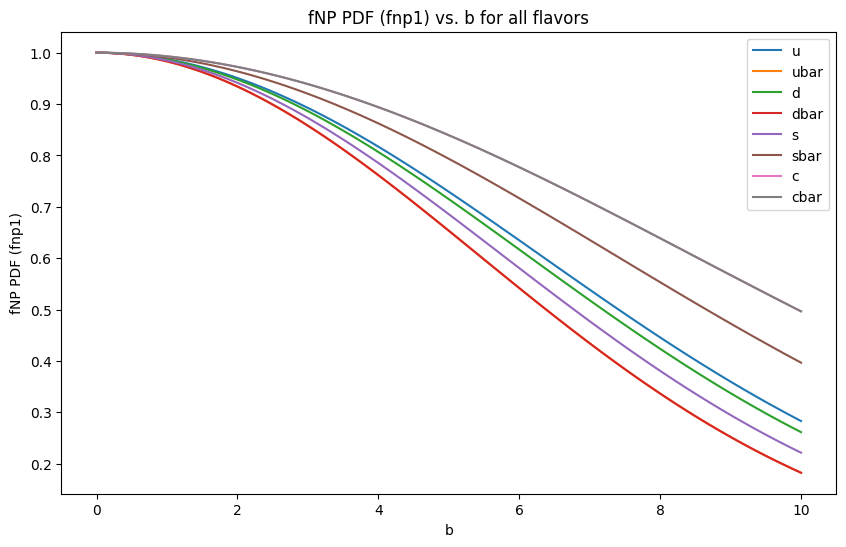

In [12]:
# Demonstration of parameter update functionality
print("=== Current Parameter Summary ===")
model_fNP.print_parameter_summary()

print("\n=== Getting Current Trainable Parameters ===")
current_params = model_fNP.get_trainable_parameters_dict()
for key, value in current_params.items():
    print(f"{key}: {value.shape} -> {value}")

print("\n=== Updating Parameters ===")
# Create a modified version of the current parameters
updated_params = {}
for key, value in current_params.items():
    if "evolution" in key:
        # Update evolution parameter
        updated_params[key] = torch.tensor(0.20)
    else:
        # For other parameters, modify slightly (multiply by 0.9)
        updated_params[key] = value * 0.9

# Set the updated parameters
model_fNP.set_trainable_parameters_dict(updated_params)

print("\n=== Evaluating with Updated Parameters ===")
results_updated = model_fNP.forward_pdf(x, b)
print("Updated results for all PDF flavors:")
for flavor, val in results_updated.items():
    print(f"{flavor}: {val.item()}")

# Call the plotting function again.
utl.plot_fNP(model_fNP, x)

# Summary

This notebook successfully demonstrates the fNP (non-perturbative TMD functions) system:

## ✅ Working Features:

1. **Automatic Path Discovery**: Robust import system that finds the correct path to `map/modules/`
2. **Configuration Loading**: Successfully loads YAML configuration files
3. **fNP Model Creation**: Creates the unified fNP manager with both PDFs and FFs
4. **Individual TMD PDF/FF Objects**: Create standalone TMD PDF and FF objects with MAP22 parameterization
5. **Model Evaluation**: 
   - Point-by-point evaluation: `forward_pdf(x, b)` for PDFs
   - Element-wise evaluation with vectors
   - Grid evaluation using meshgrids
6. **Parameter Management**: 
   - View current trainable parameters with `get_trainable_parameters_dict()`
   - Update parameters with `set_trainable_parameters_dict()`
   - Print parameter summaries
7. **Visualization**: Plot fNP functions vs. impact parameter b for all flavors

## Key Methods Used:
- `model_fNP.forward_pdf(x, b)` - Evaluate TMD PDFs  
- `model_fNP.forward_ff(z, b)` - Evaluate TMD FFs
- `model_fNP.forward(x, z, b)` - Evaluate both PDFs and FFs
- `model_fNP.get_trainable_parameters_dict()` - Get current parameters
- `model_fNP.set_trainable_parameters_dict(params)` - Update parameters
- `model_fNP.print_parameter_summary()` - Display parameter information

The system is now ready for integration with optimization routines and experimental data fitting!